In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import os
import argparse

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\rfgla\Documents\Ray\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
import torch
import pytorch_lightning as pl
from torchvision.io import read_video, read_video_timestamps
import sys
sys.path.append(r'C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master')
from videogpt import download, VQVAE, VideoGPT
from videogpt.data import VideoData
from convolutional_classifier import Classifier as ConvolutionalClassifier
from testing_functions import plot_confusion_matrix

In [2]:
# Create arg parser
vqvae_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\VideoGPT-master\lightning_logs\version_23\checkpoints\epoch=60-step=188489.ckpt"
data_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\data\gesture_sorted_data"
config = {
        "--batch_size": 1,
        "--vqvae": vqvae_path,
        "--kernel_size": 3,
        "--out_channels": 3,
        "--n_classes": 8,
        "--lr": 8e-4,
        "--gpus": 1,
        "--data_path": data_path,
    }

parser = argparse.ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser.add_argument('--data_path', type=str, default='/home/wilson/data/datasets/bair.hdf5')
parser.add_argument('--sequence_length', type=int, default=16)
parser.add_argument('--resolution', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_workers', type=int, default=8)
parser = ConvolutionalClassifier.add_model_specific_args(parser)
config_args = []
for key in config.keys():
        config_args.append(key)
        config_args.append(str(config[key]))
args = parser.parse_args(config_args)

In [3]:
# Create data loader
data = VideoData(args)
test_loader = data.test_dataloader()
args.n_classes = data.n_classes

In [4]:
# Load classifier from checkpoint
classifier_path = r"C:\Users\rfgla\Documents\Ray\telerehab_exercise_feedback\convolutional_classifier\checkpoint_61.ckpt"
device = torch.device('cuda')
model = ConvolutionalClassifier(args)
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=args.lr)

checkpoint = torch.load(classifier_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)
model.eval()

Classifier(
  (vqvae): VQVAE(
    (encoder): Encoder(
      (convs): ModuleList(
        (0): SamePadConv3d(
          (conv): Conv3d(3, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (1): SamePadConv3d(
          (conv): Conv3d(240, 240, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
      )
      (conv_last): SamePadConv3d(
        (conv): Conv3d(240, 240, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (res_stack): Sequential(
        (0): AttentionResidualBlock(
          (block): Sequential(
            (0): BatchNorm3d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): SamePadConv3d(
              (conv): Conv3d(240, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
            )
            (3): BatchNorm3d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): SamePadConv3d(
              (conv): Conv3d(120, 240, kernel_size=(1, 1

In [5]:
correct = 0
count = 0
confusion_matrix = np.zeros([args.n_classes, args.n_classes])
for idx, batch in enumerate(test_loader):
    # Send to the gpu
    video, label = batch["video"], batch["label"]
    video, label = video.to(device), label.to(device)
    with torch.no_grad():
        predictions = model(video)
        pred_label = predictions.argmax(axis=1)
        result = pred_label == label

        correct += result.sum().item()
        count += 1
        confusion_matrix[label][pred_label] += 1


In [6]:
accuracy = correct / count
print(accuracy)
acc_matrix = confusion_matrix / np.max(confusion_matrix, axis=0)
print(confusion_matrix)
print(acc_matrix)

0.6908814300656081
[[4.290e+02 8.900e+01 4.600e+01 3.700e+01 1.000e+00 8.000e+01 3.300e+01
  4.300e+01 7.300e+01]
 [1.790e+02 4.550e+02 1.600e+01 6.000e+00 8.000e+00 1.000e+00 7.000e+00
  5.700e+01 6.200e+01]
 [5.900e+01 1.900e+01 1.038e+03 0.000e+00 1.600e+01 1.940e+02 2.000e+00
  2.000e+00 4.000e+00]
 [6.000e+01 8.400e+01 0.000e+00 5.850e+02 3.600e+01 1.000e+00 3.360e+02
  6.000e+00 3.800e+01]
 [1.600e+01 2.500e+01 2.200e+01 5.000e+00 1.255e+03 5.900e+01 3.500e+01
  0.000e+00 1.000e+00]
 [1.810e+02 7.700e+01 3.650e+02 1.000e+00 1.000e+01 9.770e+02 2.800e+01
  7.000e+00 1.300e+01]
 [1.000e+01 1.030e+02 2.000e+00 1.250e+02 1.100e+02 3.000e+00 5.510e+02
  0.000e+00 4.000e+00]
 [1.000e+00 1.700e+01 3.800e+01 0.000e+00 2.500e+01 0.000e+00 1.600e+01
  1.007e+03 1.400e+02]
 [1.200e+01 7.200e+01 0.000e+00 1.000e+01 1.600e+01 4.500e+01 1.700e+01
  4.500e+01 9.690e+02]]
[[1.00000000e+00 1.95604396e-01 4.43159923e-02 6.32478632e-02
  7.96812749e-04 8.18833163e-02 5.98911071e-02 4.27010924e-02
 

True

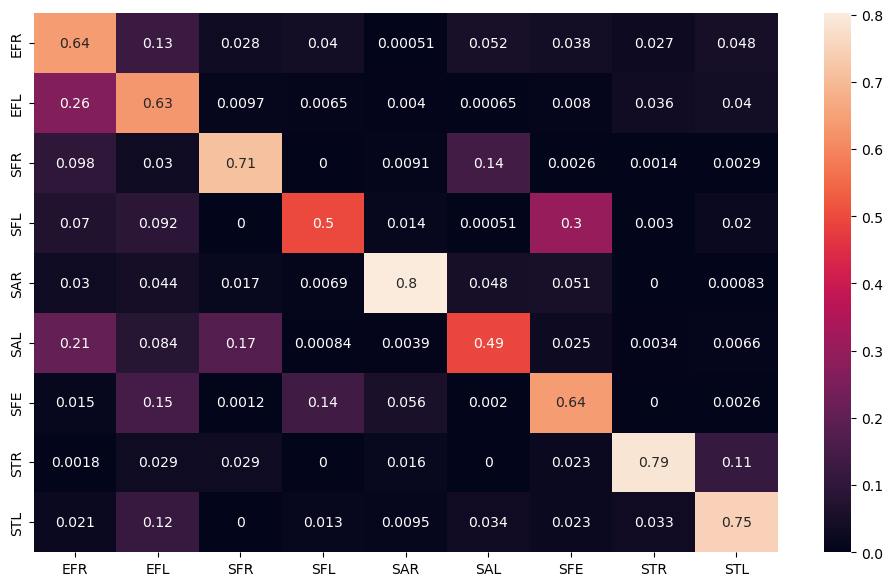

In [7]:
groups = ["EFL", "EFR", "SAL", "SAR", "SFE", "SFL", "SFR", "STL", "STR"]
plot_confusion_matrix(acc_matrix, groups)